In [1]:
"""
In this toy project we will use different audios datasets in order classify them and see the results.

The method os.chdir() must be used at the begining of the code in order to indicate where to read the data from.
Here we hide this because the notebook was run in a PC and not in the cloud because the data is to heavy to store it 
in the cloud and work with it.
"""

# datasets:
# https://www.kaggle.com/datasets/chrisfilo/urbansound8k
# https://www.kaggle.com/datasets/kenjee/z-by-hp-unlocked-challenge-3-signal-processing?select=Forest+Recordings
# https://www.kaggle.com/competitions/freesound-audio-tagging/overview

# packages
import os, warnings
import pandas as pd
from tqdm import tqdm
from time import time
import matplotlib.pyplot as plt
from prettytable import PrettyTable
warnings.filterwarnings("ignore")

# functions
def mfcc_features(file):
    
    """
    This function return the scaled features of audio data. 
    """
    
    import librosa
    import numpy as np
    
    audio, rate = librosa.load(file, res_type='kaiser_fast') # reading data
    features = librosa.feature.mfcc(y=audio, sr=rate, n_mfcc=40) # featuring data
    scaled_features = np.mean(features.T,axis=0) # scaling features
    return scaled_features

def split_data(data, test_size=0.1):
    
    """
    This function split data for modeling purposes and also return the number of labels.
    """
    
    from tensorflow.keras.utils import to_categorical as to_cat
    from sklearn.preprocessing import LabelEncoder as le
    from sklearn.model_selection import train_test_split as spl
    import numpy as np
    
    label_encoder = le() # label encoder instantiation
    
    X, y = np.array(data['feature'].tolist()), np.array(data['class'].tolist()) # spliting data in values and targets
    y = to_cat(label_encoder.fit_transform(y)) # enconding labels
    nlabels = y.shape[1] # number of labels
    X_train, X_test, y_train, y_test = spl(X, y, test_size=test_size, random_state=1234) # spliting data in training and testing sets
    return X_train, X_test, y_train, y_test, nlabels

def modelling(nlabels, nDense1=100, nDense2=200, input_shape=40, dropout_rate=0.5, 
              activation='relu', activation_output='softmax', loss='categorical_crossentropy',
              metric='accuracy', optimizer='adam'):
    
    """
    This function return a model to train audio data.
    """
    
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout, Activation
    
    model = Sequential([ # modeling
        Dense(nDense1,input_shape=(input_shape,)), Activation(activation), Dropout(dropout_rate),
        Dense(nDense2), Activation(activation), Dropout(dropout_rate),
        Dense(nDense1), Activation(activation), Dropout(dropout_rate),
        Dense(nlabels), Activation(activation_output)
        ])
    model.compile(loss=loss,metrics=[metric],optimizer=optimizer) # compiling model
    return model

forest_path, signal_path, tags_path = os.path.join(os.getcwd(), 'UrbanSound8K'), os.path.join(os.getcwd(), 'Signal Processing'), os.path.join(os.getcwd(), 'Audio Tagging') # data paths
forest_metadata, tags_metadata = pd.read_csv(os.path.join(forest_path, 'UrbanSound8K.csv')), pd.read_csv(os.path.join(tags_path, 'train.csv')) # metadata paths
urban_sounds_features, capuchins_features, non_capuchins_features, tags_features, cols = [], [], [], [], ['feature','class'] # empty lists where features are going to be store
print(forest_metadata.head(), '\n\n', tags_metadata.head()) # printing metadata

      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing   

           fname         label  manually_verified
0  00044347.wav        Hi-hat                  0
1  001ca53d.wav     Saxophone                  1
2  002d256b.wav       Trumpet                  0
3  0033e230.wav  Glockenspiel                  1
4  00353774.wav         Cello                  1


In [2]:
print("1/4") # storing in a list features of forest sounds and their corresponding labels
for idx, row in tqdm(forest_metadata.iterrows()): 
    file, label = os.path.join(os.path.abspath(forest_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"])), row["class"]
    features = mfcc_features(file)
    urban_sounds_features.append([features,label])
print("2/4") # storing in a list features of capuchin birds sounds and their corresponding labels
for idx in tqdm(os.listdir(os.path.join(signal_path, 'Parsed_Capuchinbird_Clips'))): 
    features = mfcc_features(os.path.join(signal_path, 'Parsed_Capuchinbird_Clips', idx))
    capuchins_features.append([features,'capuchin'])
print("3/4") # storing in a list features of non-capuchin birds sounds and their corresponding labels
for idx in tqdm(os.listdir(os.path.join(signal_path, 'Parsed_Not_Capuchinbird_Clips'))):
    features = mfcc_features(os.path.join(signal_path, 'Parsed_Not_Capuchinbird_Clips', idx))
    non_capuchins_features.append([features,'not_capuchin'])   
print("4/4") # storing in a list features of random sounds and their corresponding labels
for idx in tqdm(os.listdir(os.path.join(tags_path, 'audio_train'))):
    file, label = os.path.join(tags_path, 'audio_train', idx), tags_metadata[tags_metadata['fname'] == idx].label.values[0]
    features = mfcc_features(file)
    tags_features.append([features,label]) 
    
# storing data in dataframes instead of lists
urban_sounds_features, capuchins_features, non_capuchins_features, tags_features = pd.DataFrame(urban_sounds_features, columns=cols), pd.DataFrame(capuchins_features, columns=cols), pd.DataFrame(non_capuchins_features, columns=cols), pd.DataFrame(tags_features, columns=cols)
capuchins_features = pd.concat([capuchins_features, non_capuchins_features],axis=0)
print(urban_sounds_features.head(), '\n\n', capuchins_features.head(), '\n\n', tags_features.head()) # printing dataframes

1/4


8732it [13:56, 10.44it/s]


2/4


100%|████████████████████████████████████████████████████████████████████████████████| 217/217 [00:17<00:00, 12.19it/s]


3/4


100%|████████████████████████████████████████████████████████████████████████████████| 593/593 [00:49<00:00, 11.98it/s]


4/4


100%|██████████████████████████████████████████████████████████████████████████████| 9473/9473 [21:29<00:00,  7.35it/s]

                                             feature             class
0  [-217.35526, 70.22338, -130.38527, -53.282898,...          dog_bark
1  [-424.09818, 109.34077, -52.919525, 60.86475, ...  children_playing
2  [-458.79114, 121.38419, -46.520657, 52.00812, ...  children_playing
3  [-413.89984, 101.66373, -35.42945, 53.036354, ...  children_playing
4  [-446.60352, 113.68541, -52.402206, 60.302044,...  children_playing 

                                              feature     class
0  [-395.73795, 78.004654, -4.6507525, -20.90168,...  capuchin
1  [-403.898, 68.66969, -5.8758955, -19.092146, -...  capuchin
2  [-407.51825, 67.42402, -0.6788241, -12.0961895...  capuchin
3  [-406.75986, 61.02057, -12.09892, -10.199426, ...  capuchin
4  [-415.29398, 65.00564, -9.136817, -7.245201, -...  capuchin 

                                              feature         class
0  [-427.23557, 18.02058, -50.47313, 5.0084405, -...        Hi-hat
1  [-337.8687, 89.769646, -61.712486, 14.603757, ...    

In [3]:
datas = [urban_sounds_features, capuchins_features, tags_features] # dataframes
names = ['urban','capuchins','tags'] # dataframes names
datasets = ["Urban Sounds","Birds Sounds","Free Sound Tagging"] # datasets names
performances, batch_size, epochs = {}, 128, 1000 # constants for training
for data, name in zip(datas, names): # training
    
    X_train, X_test, y_train, y_test, nlabels = split_data(data) # spliting data
    model = modelling(nlabels) # modeling
    performances[f'{name}'] = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), verbose=1) # fitting models

Epoch 1/1000
62/62 [==============================] - 1s 11ms/step - loss: 19.0072 - accuracy: 0.1117 - val_loss: 2.2657 - val_accuracy: 0.1350
Epoch 2/1000
62/62 [==============================] - 1s 8ms/step - loss: 3.7106 - accuracy: 0.1229 - val_loss: 2.2948 - val_accuracy: 0.0915
Epoch 3/1000
62/62 [==============================] - 1s 8ms/step - loss: 2.6026 - accuracy: 0.1124 - val_loss: 2.2877 - val_accuracy: 0.0915
Epoch 4/1000
62/62 [==============================] - 1s 8ms/step - loss: 2.4219 - accuracy: 0.1124 - val_loss: 2.2814 - val_accuracy: 0.0915
Epoch 5/1000
62/62 [==============================] - 0s 7ms/step - loss: 2.3607 - accuracy: 0.1154 - val_loss: 2.2761 - val_accuracy: 0.0915
Epoch 6/1000
62/62 [==============================] - 0s 8ms/step - loss: 2.3266 - accuracy: 0.1199 - val_loss: 2.2721 - val_accuracy: 0.0915
Epoch 7/1000
62/62 [==============================] - 0s 7ms/step - loss: 2.3072 - accuracy: 0.1190 - val_loss: 2.2685 - val_accuracy: 0.0915
Epoc

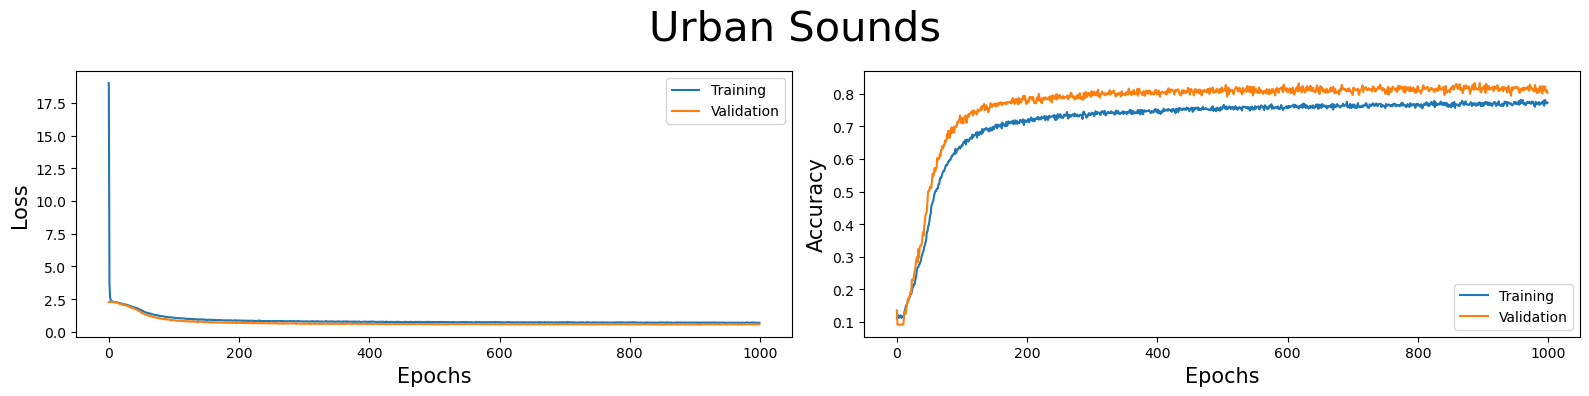

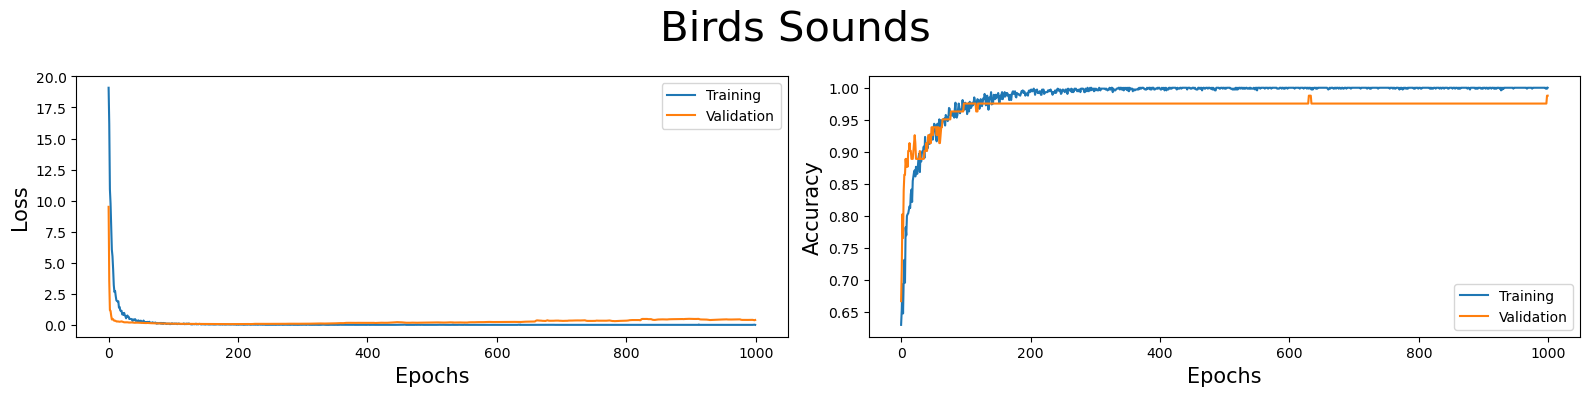

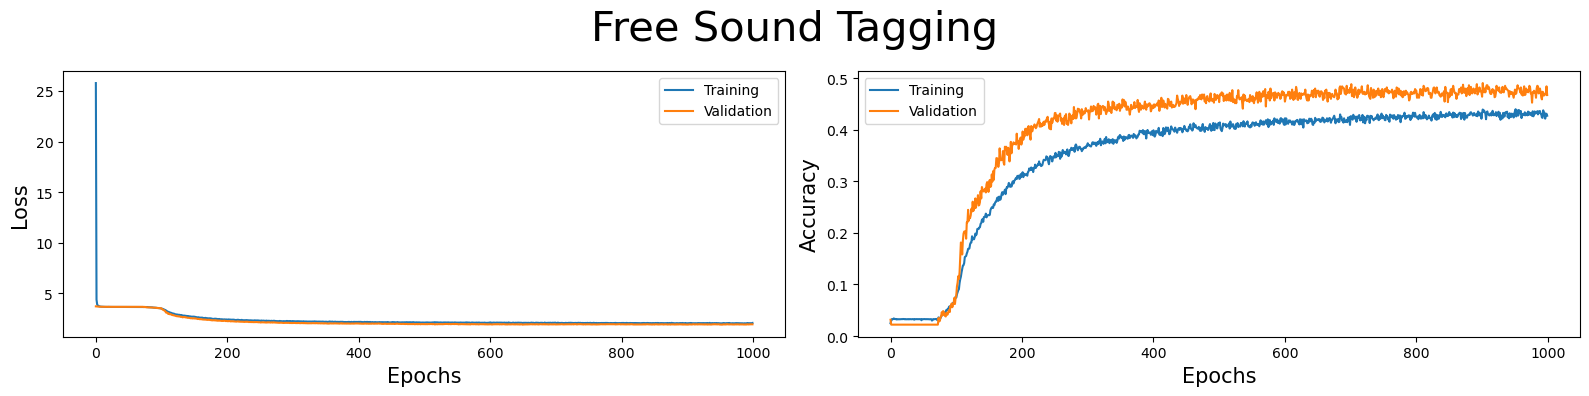

In [4]:
# plotting
for dataset, name in zip(datasets, names):
    
    plt.figure(figsize=(8*2,4*1))
    plt.subplot(1,2,1)
    plt.plot(performances[name].history['loss'], label='Training')
    plt.plot(performances[name].history['val_loss'], label='Validation')
    plt.legend(loc=0)
    plt.xlabel('Epochs',fontsize=15)
    plt.ylabel('Loss',fontsize=15)
    
    plt.subplot(1,2,2)
    plt.plot(performances[name].history['accuracy'], label='Training')
    plt.plot(performances[name].history['val_accuracy'], label='Validation')
    plt.legend(loc=0)
    plt.xlabel('Epochs',fontsize=15)
    plt.ylabel('Accuracy',fontsize=15)
    
    plt.suptitle(dataset,fontsize=30)
    plt.tight_layout()
    plt.show()

In [6]:
# statistics
table = PrettyTable()
table.title = 'Stats'
table.field_names = ['Dataset','Number of Categories','Number of Audios','Accuracy (%)','Loss (%)']
for i, name in zip(range(len(datas)), names):
    table.add_row([name,
                   datas[i]['class'].nunique(),
                   datas[i].shape[0],
                   round(performances[name].history['accuracy'][-1]*100,2),
                   round(performances[name].history['loss'][-1]*100,2)])
print(table)

+-------------------------------------------------------------------------------+
|                                     Stats                                     |
+-----------+----------------------+------------------+--------------+----------+
|  Dataset  | Number of Categories | Number of Audios | Accuracy (%) | Loss (%) |
+-----------+----------------------+------------------+--------------+----------+
|   urban   |          10          |       8732       |    77.26     |  68.16   |
| capuchins |          2           |       810        |    100.0     |   0.07   |
|    tags   |          41          |       9473       |    42.72     |  206.81  |
+-----------+----------------------+------------------+--------------+----------+


Here we can see a correlation between the number of categories and accuracy. The number of audios doesn't seems to be an indicator of models success to predict labels. 